# Phase B: Model Diagnostics & Advanced Feature Engineering
**Project:** Real Estate Price Prediction (Queretaro, Mexico)
**Objective:** Diagnose the econometric anomalies found in the Baseline BigQuery models and implement feature engineering to resolve multicollinearity and endogeneity issues.

## 1. Baseline Model "Post-Mortem" Analysis
In Phase A, we trained two baseline models using BigQuery ML:
1.  **Model A (Linear):** Target = `price` ($R^2 \approx 0.645$)
2.  **Model B (Log-Linear):** Target = `ln(price)` ($R^2 \approx 0.623$)

While the $R^2$ results successfully replicated the explanatory power of the reference paper (Guanajuato study), the coefficient analysis revealed three **econometric paradoxes** that must be addressed before model tuning:

| model\_name | feature\_name | coefficient | standard\_error | p\_value | significance\_level |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Model A \(Linear\) | \_\_INTERCEPT\_\_ | -3569918.99 | 368817.35 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_bathrooms | 688079.31 | 50238.23 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_bedrooms | -492347.23 | 65832.46 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_crime\_consolidated | 5756.01 | 399.49 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_crime\_homicide | 60931.28 | 33203.45 | 0.066 | \* Marginally Significant |
| Model A \(Linear\) | feat\_dist\_center | -122.93 | 17.66 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_dist\_park | -244.36 | 44.65 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_dist\_supermarket | 238.07 | 29.54 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_has\_garden | 354276.87 | 101621.16 | 0.0008 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_m2\_constructed | 22112.04 | 282.79 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_parking\_spots | 486444.87 | 28637.46 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | \_\_INTERCEPT\_\_ | 14.0734 | 0.0365 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_bathrooms | 0.1811 | 0.0051 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_bedrooms | -0.0272 | 0.0066 | 0.0001 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_crime\_consolidated | 0.0005 | 0 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_crime\_homicide | -0.0121 | 0.0033 | 0.0004 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_dist\_center | 0 | 0 | 0.7211 | Not Significant \(Likely Noise\) |
| Model B \(Log-Linear\) | feat\_dist\_park | -0 | 0 | 0.1956 | Not Significant \(Likely Noise\) |
| Model B \(Log-Linear\) | feat\_dist\_supermarket | 0 | 0 | 0.0874 | \* Marginally Significant |
| Model B \(Log-Linear\) | feat\_has\_garden | 0.1832 | 0.0102 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_m2\_constructed | 0.002 | 0 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_parking\_spots | 0.0393 | 0.0029 | 0 | \*\*\* Highly Significant |


### A. The "Negative Bedroom" Paradox
* **Observation:** The coefficient for `feat_bedrooms` was **negative** (-492,347 MXN in Linear model).
* **Interpretation:** The model suggests that adding a bedroom *reduces* the house value by half a million pesos, holding other factors constant.
* **Diagnosis:** High probability of **Multicollinearity**. Since `feat_m2_constructed` (size) is already in the model, `bedrooms` and `size` are fighting to explain the same variance. A small house with many rooms implies tiny, lower-value rooms.

### B. The "Crime Value" Paradox
* **Observation:** The coefficient for `feat_crime_consolidated` was **positive** (+5,756 MXN).
* **Interpretation:** The model implies that higher crime rates are associated with *higher* property values.
* **Diagnosis:** **Endogeneity / Omitted Variable Bias**. Crime is likely acting as a proxy for **economic activity**. Wealthy areas attract more opportunistic crime than undeveloped areas. The model is confusing "wealthy target" with "valuable location."

### C. The "Vanishing Distance" Effect
* **Observation:** In the Log-Linear Model (Model B), distance variables (Park, Center) became statistically insignificant ($p\text{-value} > 0.05$).
* **Diagnosis:** The logarithmic transformation of the price compressed the variance so much that the subtle linear effect of distance was lost. This suggests the relationship between distance and price might be non-linear or strictly local (e.g., only matters within 500m).

---
## 2. Hypothesis & Action Plan
To resolve these issues and improve $R^2$ > 0.70, we will test the following hypotheses:

1. **H1 (Interaction Features):** Creating interaction terms (e.g., `bathrooms_per_bedroom`) will resolve the multicollinearity between size and room counts.

2. **H2 (Multicollinearity):** Removing `bedrooms` or creating an interaction term (e.g., `bathrooms_per_bedroom`) will stabilize the coefficients of physical characteristics.
3. **H3 (Crime Unbundling):** Instead of a consolidated crime rate, we will separate **Violent Crime** (expected negative impact) from **Property Crime** (proxy for wealth) to isolate the true "fear factor."
4. **H4 (Rich Features):** Incorporating specific amenities (Schools, Hospitals) will capture the variance currently attributed to "noise" in the Baseline.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dotenv import load_dotenv

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Initialize BigQuery Client
load_dotenv()

try:
    client = bigquery.Client()
    print("Successful connection to BigQuery (Authenticated via Environment Variables)")
except Exception as e:
    print(f"Connection Error: {e}")
    print("Tip: Verify that your .env file has the correct path to the JSON.")

print("Libraries loaded. Ready for diagnostics.")

C:\Users\a-b-e\anaconda3\envs\real_estate_ds\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Successful connection to BigQuery (Authenticated via Environment Variables)
Libraries loaded. Ready for diagnostics.


## 3. Data Loading: Unleashing the Full OBT (One Big Table)

In Phase A (Baseline), we intentionally restricted our analysis to a limited subset of variables to strictly replicate the methodology of the reference paper (Guanajuato study).

**Transition to Phase B:**
Now that the baseline is established, we proceed to unlock the full potential of our **One Big Table (OBT)**. Unlike the original study, our dataset includes a richer set of granular features collected from multiple sources.

**Key Additions in this Phase:**
* **Crime Granularity:** Instead of a consolidated sum, we access specific crime types (Homicide, Burglary, Violence, Vehicle Theft) to test the "Unbundling" hypothesis.
* **Expanded Amenities:** We include previously unused proximity features (Schools, Hospitals, etc.) to capture value drivers that were treated as "noise" in the baseline.
* **Full Physical Specs:** Detailed breakdown of property characteristics (e.g., Half-bathrooms, Age of construction).

We will now query the full `view_training_data_cleaned` to perform the advanced diagnostic.

In [2]:
# Query to fetch all potential features + target
query = """
SELECT
    -- Listing ID
    listing_id,

    -- Target
    target_price,

    -- Physical Features
    feat_m2_constructed,
    feat_m2_terrain,
    feat_bedrooms,
    feat_bathrooms,
    feat_parking_spots,

    -- Amenities
    feat_is_new,
    feat_has_security,
    feat_has_garden,
    feat_has_pool,
    feat_has_gym,
    feat_has_kitchen,
    feat_has_terrace,

    -- Municipality
    feat_municipality,

    -- Geographic Features (Distances)
    feat_dist_school,
    feat_dist_university,
    feat_dist_hospital,
    feat_dist_mall,
    feat_dist_park,
    feat_dist_industrial,
    feat_dist_green_area,
    feat_dist_playground,
    feat_dist_service,
    feat_dist_convenience,
    feat_dist_market,
    feat_dist_supermarket,
    feat_dist_center,
    feat_dist_tourism,

    -- Crime Features (Raw Counts)
    feat_crime_residential,
    feat_crime_vehicle,
    feat_crime_passerby,
    feat_crime_homicide,
    feat_crime_injueries,
    feat_crime_drug_dealing,
    feat_crime_violent

FROM `real-estate-qro.queretaro_data_marts.obt_listings_valuation_features`
WHERE target_price IS NOT NULL
"""

# Load to DataFrame
df = client.query(query).to_dataframe()

# Quick sanity check
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

C:\Users\a-b-e\anaconda3\envs\real_estate_ds\lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Dataset Shape: 11840 rows, 36 columns


,listing_id,target_price,feat_m2_constructed,feat_m2_terrain,feat_bedrooms,feat_bathrooms,feat_parking_spots,feat_is_new,feat_has_security,feat_has_garden,...,feat_dist_supermarket,feat_dist_center,feat_dist_tourism,feat_crime_residential,feat_crime_vehicle,feat_crime_passerby,feat_crime_homicide,feat_crime_injueries,feat_crime_drug_dealing,feat_crime_violent
0,242954b8c44599b049768ae9892a8101,3300000.000,39000.000,39000.000,5.000,5.000,5.000,1,0,0,...,16135.467,16371.798,2437.980,26.621,0.000,3.328,9.983,126.452,29.949,0.000
1,0202c82d0c6a8a1f08dba979d4917c84,4440000.000,290.000,212.000,3.000,3.000,2.000,1,0,1,...,20000.000,9662.670,12920.501,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,4c83388de8b58047f75e9229b3e27fae,3000000.000,124.000,90.000,3.000,3.000,1.000,1,0,1,...,20000.000,1844.340,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2fb020747d1f874a915cecdb76ce8996,2690000.000,150.000,115.000,3.000,3.000,2.000,1,1,1,...,17730.578,16905.141,8779.006,53.115,5.902,0.000,0.000,132.786,20.656,2.951
4,4b5993d3004095aea3cce48a00b43abf,2990000.000,175.000,115.000,3.000,3.000,2.000,1,1,1,...,17730.578,16905.141,8779.006,53.115,5.902,0.000,0.000,132.786,20.656,2.951


## 4. Data Cleansing & Understanding
**Objective:** Transform raw OBT data into a reliable, logic-consistent dataset.
Instead of treating validation and cleaning as separate phases, we apply a **"Detect & Fix"** strategy per variable group.

**Methodology per Group:**
1.  **Structural Integrity:** Checking for duplicates, unexpected NaNs, and data types.
2.  **Business Logic:** Enforcing real-world real estate rules (e.g., *Construction Area* cannot exceed *Terrain Area* in single-family homes).
3.  **Statistical Cleaning:** Handling extreme outliers and rare categories that generate noise.

---

### 4.1. Global Health Check
Before diving into specific columns, we assess the dataset's overall health.
* **Action:** Remove full-row duplicates.
* **Action:** Drop columns with >50% missing data (unless specifically imputable).

In [3]:
# 1. Initial Snapshot
initial_rows = df.shape[0]
print(f"Initial Row Count: {initial_rows:,}")

# 2. Identify and Remove Exact Duplicates (Full Row)
# We look for rows where all columns are identical
duplicates_mask = df.duplicated(keep='first')
n_exact_dupes = duplicates_mask.sum()

if n_exact_dupes > 0:
    # We remove duplicates and reset the index to keep the dataframe clean
    df = df[~duplicates_mask].reset_index(drop=True)
    print(f"Removed {n_exact_dupes:,} exact duplicate rows ({(n_exact_dupes/initial_rows):.2%})")
else:
    print("No exact duplicates found. SQL logic worked perfectly.")

# 3. ID Integrity Verification (Business Key Check)
# Sometimes the ID repeats but the content varies (e.g., price updates creating new rows)
if 'listing_id' in df.columns:
    # Check for duplicates specifically in the Primary Key
    id_dupes = df.duplicated(subset=['listing_id'], keep='first').sum()

    if id_dupes > 0:
        print(f"WARNING: Found {id_dupes:,} listings with duplicated IDs but different content.")
        print("    -> Taking action: Keeping only the first occurrence per ID to ensure uniqueness.")

        # Corrective Action: Keep the first occurrence (assuming chronological load order)
        df = df.drop_duplicates(subset=['listing_id'], keep='first').reset_index(drop=True)
        print(f"    -> Removed {id_dupes:,} ID duplicates.")
    else:
        print("Primary Key integrity confirmed (All 'listing_id' are unique).")

# 4. Final Report
final_rows = df.shape[0]
data_loss = initial_rows - final_rows

print("-" * 40)
print(f"Final Row Count:    {final_rows:,}")
print(f"Total Data Dropped: {data_loss:,} rows ({(data_loss/initial_rows):.2%})")
print("-" * 40)

Initial Row Count: 11,840
No exact duplicates found. SQL logic worked perfectly.
Primary Key integrity confirmed (All 'listing_id' are unique).
----------------------------------------
Final Row Count:    11,840
Total Data Dropped: 0 rows (0.00%)
----------------------------------------


In [4]:
# 1. Calculate Missing Percentage per Column
missing_series = df.isnull().mean()
missing_cols = missing_series[missing_series > 0]

# 2. Reporting
if not missing_cols.empty:
    print(f"Found {len(missing_cols)} columns with missing values:")

    # Create a temporary DataFrame for a cleaner report
    report = pd.DataFrame({
        'Missing %': missing_series * 100,
        'Count': df.isnull().sum()
    })
    # Display only columns with missing values, sorted descending
    display(report[report['Count'] > 0].sort_values(by='Missing %', ascending=False))
else:
    print("No missing values found. SQL `COALESCE` logic worked perfectly.")

# 3. Apply the 50% Threshold Rule (Drop Columns)
# If a column is more than 50% empty, it provides insufficient signal for the model.
THRESHOLD = 0.50
cols_to_drop = missing_series[missing_series > THRESHOLD].index.tolist()

if cols_to_drop:
    print(f"\nDROPPING {len(cols_to_drop)} columns with >{THRESHOLD:.0%} missing data:")
    print(f"   -> Columns: {cols_to_drop}")

    df = df.drop(columns=cols_to_drop)
    print("   -> Action completed successfully.")
else:
    print(f"\nNo columns exceeded the {THRESHOLD:.0%} missing threshold.")

# 4. Final Sanity Check (Residuals)
# Check if any small amount of NaNs remain (e.g., <50%) to be handled later.
remaining_nans = df.isnull().sum().sum()

if remaining_nans > 0:
    print(f"\nNote: There are still {remaining_nans} missing values scattered across the dataset.")
    print("   -> These must be handled in the specific Imputation Step (if applicable).")
else:
    print("\nDataset is 100% complete (No NaNs). Ready for the next step.")

No missing values found. SQL `COALESCE` logic worked perfectly.

No columns exceeded the 50% missing threshold.

Dataset is 100% complete (No NaNs). Ready for the next step.


### 4.2. Target Variable Validation (`price`)
We must ensure the target variable represents valid **Market Sale Prices**.
* **Logic Check:** Remove prices $\le 0$ (impossible).
* **Business Consistency:** Remove prices that look like "Rentals" (e.g., $<\$100,000$ MXN).
* **Outlier Detection:** Inspect the upper bound for extreme luxury properties that might skew a standard Linear Regression model.


Initial Statistics:
count         11840.000000
mean        7532069.032855
std        89478008.881699
min          150000.000000
25%         3150000.000000
50%         4350000.000000
75%         6950000.000000
max      9700000000.000000
Name: target_price, dtype: object


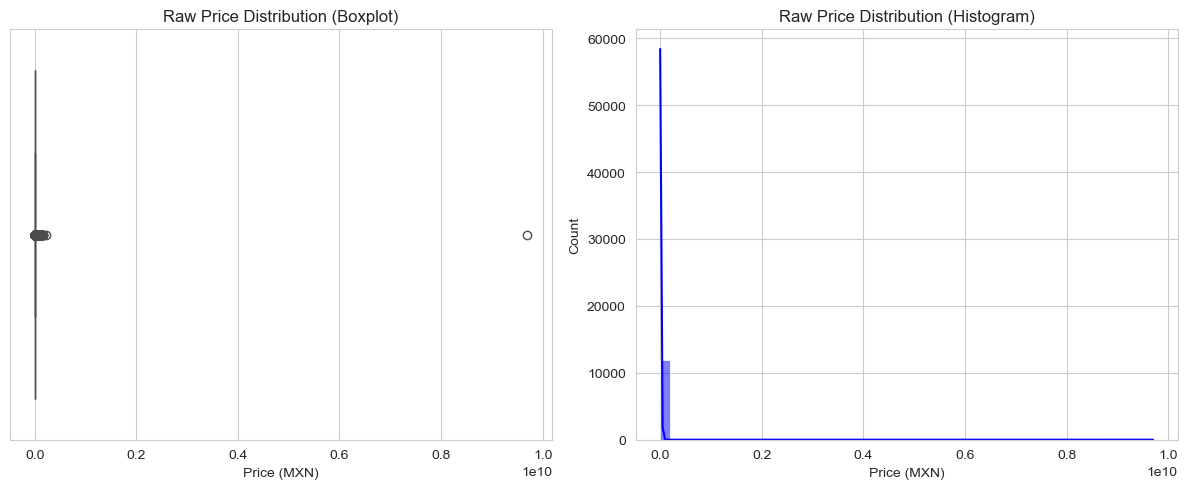


No suspicious low prices found (< $100,000).
----------------------------------------
Final Row Count: 11,840
Removed 0 zeros and 0 low-price artifacts.
----------------------------------------


In [5]:
target_col = 'target_price'
min_price_threshold = 100000  # Threshold: Houses below $100k MXN are likely errors or rentals

# 1. Initial Statistics
print("\nInitial Statistics:")
print(df[target_col].describe().apply(lambda x: format(x, 'f')))

# 2. Visual Diagnosis (Before Cleaning)
# We use a Boxplot to see the outliers clearly
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df[target_col], color='orange')
plt.title('Raw Price Distribution (Boxplot)')
plt.xlabel('Price (MXN)')

plt.subplot(1, 2, 2)
sns.histplot(df[target_col], bins=50, kde=True, color='blue')
plt.title('Raw Price Distribution (Histogram)')
plt.xlabel('Price (MXN)')

plt.tight_layout()
plt.show()

# 3. Logic & Business Cleaning
# Step A: Remove Non-Positive Prices (<= 0)
initial_count = df.shape[0]
df = df[df[target_col] > 0]
zeros_removed = initial_count - df.shape[0]

# Step B: Remove "Rentals" or Data Errors (Low Threshold)
# Assuming a house cannot be sold for less than min_price_threshold
low_price_mask = df[target_col] < min_price_threshold
n_low_prices = low_price_mask.sum()

if n_low_prices > 0:
    print(f"\nFound {n_low_prices} listings with price < ${min_price_threshold:,.0f}.")
    print("    -> These are likely rentals or data entry errors.")
    print("    -> ACTION: Removing them to preserve model integrity.")

    df = df[~low_price_mask]
else:
    print(f"\nNo suspicious low prices found (< ${min_price_threshold:,.0f}).")

# 4. Final Report
print("-" * 40)
print(f"Final Row Count: {df.shape[0]:,}")
print(f"Removed {zeros_removed} zeros and {n_low_prices} low-price artifacts.")
print("-" * 40)

Preliminary analysis reveals extreme outliers in the target variable, with a maximum value of **\$9.7 Billion MXN**. In the context of a residential housing model, values of this magnitude typically indicate:
1.  **Data Entry Errors:** Extra zeros added by mistake (e.g., $\$$9.7M becoming \$9.7B).
2.  **Scope Mismatch:** Commercial properties, industrial parks, or macro-lots (land for development) incorrectly categorized as "residential listings."

**Strategy: Hard Cap vs. Transformation**
While Log-Transformation is standard for handling the natural right-skew of monetary data, it is **not** a substitute for data cleaning. Transforming an erroneous data point (e.g., a factory price) merely compresses the error; it does not remove the noise.

**Action:**
We apply a **Domain-Specific Hard Cap** of **\$90,000,000 MXN**.
* **Rationale:** This threshold preserves the valid "Ultra-Luxury" residential segment while eliminating non-residential noise and data errors.
* **Benefit:** This prevents "High Leverage Points" from disproportionately pulling the Linear Regression line, ensuring the model generalizes well for the vast majority of the market.

,target_price,feat_m2_constructed,feat_municipality
7415,9700000000.000,250.000,QUERETARO
96,221795600.000,0.000,COLON
8581,172000000.000,0.000,QUERETARO
9220,164000000.000,0.000,QUERETARO
6434,160000000.000,0.000,QUERETARO
8016,160000000.000,6038.000,QUERETARO
10385,129000000.000,146.000,QUERETARO
10388,129000000.000,146.000,QUERETARO
10389,129000000.000,146.000,QUERETARO
6450,128833000.000,0.000,QUERETARO



--- APPLYING LUXURY CAP (< $90,000,000) ---
Detected 18 extreme outliers (likely non-residential or errors).
    -> Dropping listings with price >= $90,000,000


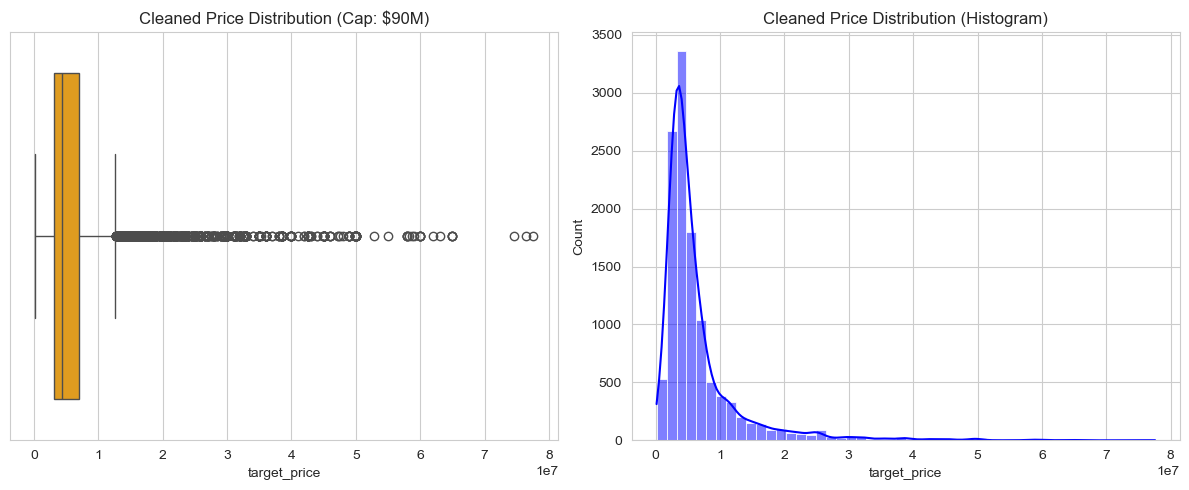

----------------------------------------
Final Row Count: 11,822
----------------------------------------


In [6]:
# 1. Inspect the "Billionaire" listings
# Show top 10 most expensive listings
top_expensive = df.sort_values(by=target_col, ascending=False).head(10)
display(top_expensive[[target_col, 'feat_m2_constructed', 'feat_municipality']])

# 2. Define a "Sanity Cap" based on Domain Knowledge
# In Queretaro residential market, anything above 100 Million is likely:
# a) A Macro-lot (Land for developers)
# b) Industrial
# c) A typo (extra zero)
HARD_CAP = 90_000_000  # 90 Million MXN Cap

print(f"\n--- APPLYING LUXURY CAP (< ${HARD_CAP:,.0f}) ---")

# Count how many we are dropping
outliers_mask = df[target_col] >= HARD_CAP
n_outliers = outliers_mask.sum()

if n_outliers > 0:
    print(f"Detected {n_outliers} extreme outliers (likely non-residential or errors).")
    print(f"    -> Dropping listings with price >= ${HARD_CAP:,.0f}")

    # Filter
    df = df[~outliers_mask]
else:
    print("No extreme outliers found above the cap.")

# 3. Re-Visualize (Sanity Check)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df[target_col], color='orange')
plt.title(f'Cleaned Price Distribution (Cap: ${HARD_CAP/1e6:.0f}M)')

plt.subplot(1, 2, 2)
sns.histplot(df[target_col], bins=50, kde=True, color='blue')
plt.title('Cleaned Price Distribution (Histogram)')

plt.tight_layout()
plt.show()

print("-" * 40)
print(f"Final Row Count: {df.shape[0]:,}")
print("-" * 40)

### 4.3. Geographic & Categorical Cleaning (`municipality`, `type`)
Addressing cardinality and representation issues.
* **Imbalance Check:** Analyze the distribution of listings per municipality.
* **Fix:** Apply **"Rare Label Encoding"**. Municipalities with insufficient data (e.g., $N < 100$) will be grouped into an `OTHER` category to maintain model stability.

Total Municipalities found: 16


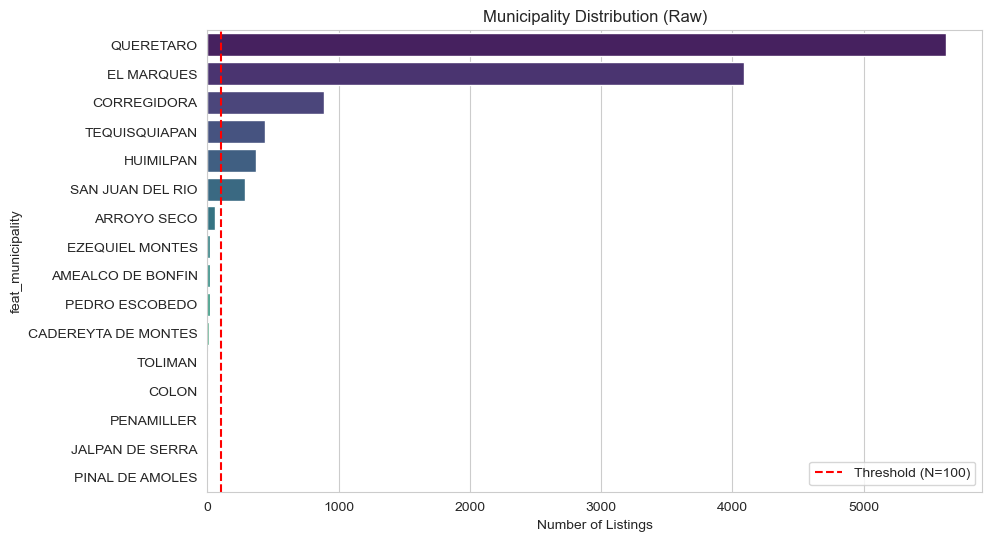


Dimensionality Reduction:
   -> Keeping 6 major municipalities.
   -> Grouping 10 rare municipalities into 'OTHER'.
      (Rare examples: ['ARROYO SECO', 'EZEQUIEL MONTES', 'AMEALCO DE BONFIN', 'PEDRO ESCOBEDO', 'CADEREYTA DE MONTES']...)

New Distribution:
feat_municipality
QUERETARO           5623
EL MARQUES          4086
CORREGIDORA          889
TEQUISQUIAPAN        437
HUIMILPAN            367
SAN JUAN DEL RIO     283
OTHER                137
Name: count, dtype: int64


In [7]:
# 1. Analyze Distribution
# We count listings per municipality to identify the "Long Tail"
muni_counts = df['feat_municipality'].value_counts()
print(f"Total Municipalities found: {len(muni_counts)}")

# 2. Visualize (Before Cleaning)
plt.figure(figsize=(10, 6))
sns.barplot(x=muni_counts.values, y=muni_counts.index, palette='viridis', hue=muni_counts.index, legend=False)
plt.title('Municipality Distribution (Raw)')
plt.xlabel('Number of Listings')
plt.axvline(x=100, color='red', linestyle='--', label='Threshold (N=100)')
plt.legend()
plt.show()

# 3. Apply Grouping Logic (Rare Label Encoding)
THRESHOLD = 100
valid_munis = muni_counts[muni_counts >= THRESHOLD].index.tolist()
rare_munis = muni_counts[muni_counts < THRESHOLD].index.tolist()

print(f"\nDimensionality Reduction:")
print(f"   -> Keeping {len(valid_munis)} major municipalities.")
print(f"   -> Grouping {len(rare_munis)} rare municipalities into 'OTHER'.")
print(f"      (Rare examples: {rare_munis[:5]}...)")

# Apply the transformation
df['feat_municipality'] = df['feat_municipality'].apply(lambda x: x if x in valid_munis else 'OTHER')

# 4. Verification
new_counts = df['feat_municipality'].value_counts()
print("\nNew Distribution:")
print(new_counts)

### 4.4. Discrete Variables (`bedrooms`, `bathrooms`, `parking`)
We validate integer-based features that define the property's structure.
**Logical Constraints applied:**
1.  **Bathrooms $\ge 1$:** A residential property must have at least one bathroom to be habitable. Records with 0 are treated as missing/erroneous data.
2.  **Bedrooms $\ge 0$:** We accept 0 bedrooms as valid "Studio/Loft" apartments.
3.  **Outlier Caps:** We inspect and flag extreme values (e.g., $>10$ bathrooms) that likely represent commercial properties (hotels, offices) rather than single-family homes.

                     min   50%     max  mean
feat_bedrooms      0.000 3.000 100.000 3.258
feat_bathrooms     0.000 3.000  25.000 2.972
feat_parking_spots 0.000 2.000  48.000 2.408


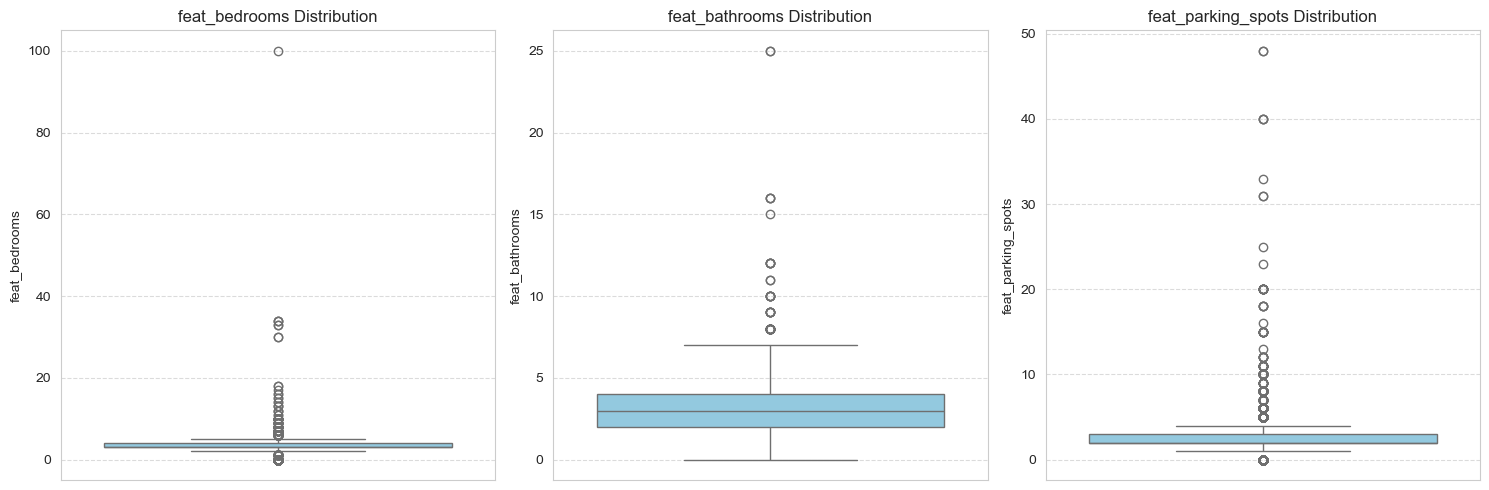


Found 356 listings with 0 bathrooms.
    -> Logic: Residential properties must have at least 1 bathroom.
    -> ACTION: Removing these rows as 'Incomplete Data'.

    -> Max value: 34.0


,listing_id,target_price,feat_m2_constructed,feat_m2_terrain,feat_bedrooms,feat_bathrooms,feat_parking_spots,feat_is_new,feat_has_security,feat_has_garden,...,feat_dist_supermarket,feat_dist_center,feat_dist_tourism,feat_crime_residential,feat_crime_vehicle,feat_crime_passerby,feat_crime_homicide,feat_crime_injueries,feat_crime_drug_dealing,feat_crime_violent
659,c0046acfe86099bc392e9e5a3dd3e47f,30000000.000,2000.000,2000.000,15.000,25.000,20.000,1,0,1,...,5395.673,6069.019,956.175,78.309,53.765,22.207,4.675,191.683,25.714,29.220
843,9cebe348f36eedad5b71d6f7026a9083,30000000.000,2000.000,2000.000,15.000,25.000,20.000,1,0,1,...,5395.673,6069.019,956.175,78.309,53.765,22.207,4.675,191.683,25.714,29.220
7107,7d3e81aba2ef427fe913138255a0bbb4,22000000.000,523.000,2817.000,13.000,2.000,0.000,1,0,0,...,717.969,494.340,466.706,71.178,217.800,122.169,6.350,212.019,135.722,111.554



    -> Max value: 25.0


,listing_id,target_price,feat_m2_constructed,feat_m2_terrain,feat_bedrooms,feat_bathrooms,feat_parking_spots,feat_is_new,feat_has_security,feat_has_garden,...,feat_dist_supermarket,feat_dist_center,feat_dist_tourism,feat_crime_residential,feat_crime_vehicle,feat_crime_passerby,feat_crime_homicide,feat_crime_injueries,feat_crime_drug_dealing,feat_crime_violent
743,71e6a625a39ac393d5f8408a029385fb,58700000.000,2500.000,15000.000,6.000,11.000,12.000,0,1,1,...,5395.673,6069.019,956.175,78.309,53.765,22.207,4.675,191.683,25.714,29.220
8267,12b42ebfe5a1e2690dcfe2953d6ced1a,31000000.000,4081.000,1731.000,10.000,11.000,0.000,0,1,1,...,674.773,1174.937,2500.105,71.178,217.800,122.169,6.350,212.019,135.722,111.554
659,c0046acfe86099bc392e9e5a3dd3e47f,30000000.000,2000.000,2000.000,15.000,25.000,20.000,1,0,1,...,5395.673,6069.019,956.175,78.309,53.765,22.207,4.675,191.683,25.714,29.220



    -> Max value: 48.0


,listing_id,target_price,feat_m2_constructed,feat_m2_terrain,feat_bedrooms,feat_bathrooms,feat_parking_spots,feat_is_new,feat_has_security,feat_has_garden,...,feat_dist_supermarket,feat_dist_center,feat_dist_tourism,feat_crime_residential,feat_crime_vehicle,feat_crime_passerby,feat_crime_homicide,feat_crime_injueries,feat_crime_drug_dealing,feat_crime_violent
743,71e6a625a39ac393d5f8408a029385fb,58700000.000,2500.000,15000.000,6.000,11.000,12.000,0,1,1,...,5395.673,6069.019,956.175,78.309,53.765,22.207,4.675,191.683,25.714,29.220
8388,5f292334a6982ee8df3e3d45d83f4d8b,45000000.000,7000.000,1200.000,7.000,9.000,18.000,0,1,1,...,674.773,1174.937,2500.105,71.178,217.800,122.169,6.350,212.019,135.722,111.554
11362,07b7a9d0ecd237220fe44fa161973698,45000000.000,1292.000,1546.000,5.000,7.000,25.000,0,1,1,...,2088.728,4153.745,3481.941,71.178,217.800,122.169,6.350,212.019,135.722,111.554


----------------------------------------
Final Row Count: 11,466
----------------------------------------


In [8]:
discrete_cols = ['feat_bedrooms', 'feat_bathrooms', 'feat_parking_spots']

# 1. Statistical Snapshot
# We use describe() to spot max values like 100 bedrooms
print(df[discrete_cols].describe().T[['min', '50%', 'max', 'mean']])

# 2. Visual Inspection (Boxplots)
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols):
    plt.subplot(1, 3, i+1)
    # Use stripplot + boxplot to see density and outliers
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'{col} Distribution')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3. Logic Filter: The "Habitability" Rule
# Rule: A house MUST have at least 1 bathroom.
# 0 bathrooms usually means missing data or a commercial shell.
zero_baths_mask = df['feat_bathrooms'] == 0
n_zero_baths = zero_baths_mask.sum()

if n_zero_baths > 0:
    print(f"\nFound {n_zero_baths} listings with 0 bathrooms.")
    print("    -> Logic: Residential properties must have at least 1 bathroom.")
    print("    -> ACTION: Removing these rows as 'Incomplete Data'.")

    df = df[~zero_baths_mask]
else:
    print("\nAll listings have at least 1 bathroom.")

# 4. Outlier Cap (Soft Cap)
# Properties with >10 bedrooms/bathrooms/parking are likely Commercial or Errors
# We won't delete them blindly, but we will print a warning.
for col in discrete_cols:
    high_vals = df[df[col] > 10]
    if not high_vals.empty:
        print(f"\nWarning: Found {len(high_vals)} listings with {col} > 10.")
        print(f"    -> Max value: {high_vals[col].max()}")
        display(high_vals.sort_values(by='target_price', ascending=False).head(3))

# 5. Final Count
print("-" * 40)
print(f"Final Row Count: {df.shape[0]:,}")
print("-" * 40)

Statistical analysis and boxplots revealed extreme outliers in discrete structural variables:
* **Bedrooms:** Max 34
* **Bathrooms:** Max 25
* **Parking Spots:** Max 48

**Conclusion:**
Upon inspecting specific records (e.g., ID `c0046...` with 25 baths and 15 bedrooms), we confirmed these likely represent **Commercial Properties** (Boutique Hotels, Guest Houses) or **Data Entry Errors**, rather than standard residential listings. Including them would introduce significant noise, causing the model to overestimate values based on non-residential features.

**Action:**
We apply a **"Residential Cap"** of **10 units**.
* **Rule:** Remove any listing where `Bedrooms > 10` OR `Bathrooms > 10` OR `Parking > 10`.
* **Goal:** To ensure the dataset strictly represents the Single-Family Home & Apartment market.

In [9]:
initial_rows = df.shape[0]

# 1. Define the "Residential Cap"
# We treat anything above 10 as non-residential (Commercial/Hotel/Error)
OUTLIER_THRESHOLD = 10

mask_outliers = (
    (df['feat_bedrooms'] > OUTLIER_THRESHOLD) |
    (df['feat_bathrooms'] > OUTLIER_THRESHOLD) |
    (df['feat_parking_spots'] > OUTLIER_THRESHOLD)
)

n_outliers = mask_outliers.sum()

if n_outliers > 0:
    print(f"Removing {n_outliers} non-residential listings (Hotels/Commercial).")
    print(f"    -> Criteria: Any discrete feature > {OUTLIER_THRESHOLD}")

    df = df[~mask_outliers]
else:
    print("No discrete outliers found.")

print("-" * 40)
print(f"Final Row Count: {df.shape[0]:,}")
print("-" * 40)

Removing 78 non-residential listings (Hotels/Commercial).
    -> Criteria: Any discrete feature > 10
----------------------------------------
Final Row Count: 11,388
----------------------------------------


### 4.5. Continuous & Spatial Validation (`m2`, `distances`)

---

#### 4.5.1. Area Validation (`m2_constructed` vs `m2_terrain`)

**Logic & Constraints:**
1.  **Non-Negative Check:** Physical area cannot be negative.
2.  **Minimum Habitable Area:** We discard listings with `m2_constructed < 30`. These are likely land lots incorrectly labeled as houses, or data entry errors (e.g., "0 m2").
3.  **The "Verticality" Nuance:**
    * We **DO NOT** strictly enforce `m2_constructed <= m2_terrain`.
    * *Reason:* Apartments often have a construction area larger than their pro-rated share of the land (indiviso).
    * *Control:* Instead, we inspect the **Floor Area Ratio (FAR)**. We only flag/remove extreme anomalies (e.g., Construction > 20x Terrain) that are physically impossible for standard residential zoning.

In [10]:
# 1. Sanity Check: Remove Negatives
# It's impossible to have negative area
cols_m2 = ['feat_m2_constructed', 'feat_m2_terrain']
neg_mask = (df[cols_m2] < 0).any(axis=1)

if neg_mask.sum() > 0:
    print(f"Removing {neg_mask.sum()} rows with negative m2 values.")
    df = df[~neg_mask]

# 2. The "Ghost House" Filter (Minimum Viable Product)
# A house must have at least 30m2 of construction.
MIN_M2_CONSTRUCTED = 30
small_house_mask = df['feat_m2_constructed'] < MIN_M2_CONSTRUCTED
n_small = small_house_mask.sum()

if n_small > 0:
    print(f"Removing {n_small} listings with < {MIN_M2_CONSTRUCTED} m2 constructed.")
    print("    -> Reason: Likely Land Lots (Terrenos) misclassified as Houses.")
    df = df[~small_house_mask]

# 3. Density/Ratio Check (Handling the Vertical Market)
# We create a temporary metric: Floor Area Ratio (FAR) = Construction / Terrain
# Note: We replace 0 terrain with 1 to avoid DivisionByZero errors
df['density_ratio'] = df['feat_m2_constructed'] / df['feat_m2_terrain'].replace(0, 1)

# Threshold: If Construction is 20x the Terrain, it's likely an error
# (unless it's a 20-story building, which is rare in this specific dataset context)
DENSITY_CAP = 20
high_density_mask = df['density_ratio'] > DENSITY_CAP
n_high_density = high_density_mask.sum()

if n_high_density > 0:
    print(f"Removing {n_high_density} listings with extreme density (Construction > {DENSITY_CAP}x Terrain).")
    print("    -> Example: 200m2 built on 5m2 land (likely data error).")
    df = df[~high_density_mask]
else:
    print(f"No extreme density anomalies found (Max Ratio allowed: {DENSITY_CAP}x).")

# Clean up temporary column
df.drop(columns=['density_ratio'], inplace=True)

print("-" * 40)
print(f"Rows after Area Validation: {df.shape[0]:,}")
print("-" * 40)

Removing 242 listings with < 30 m2 constructed.
    -> Reason: Likely Land Lots (Terrenos) misclassified as Houses.
Removing 61 listings with extreme density (Construction > 20x Terrain).
    -> Example: 200m2 built on 5m2 land (likely data error).
----------------------------------------
Rows after Area Validation: 11,085
----------------------------------------


#### 4.5.2. Spatial Validation (Distances)

**Focus: Geographic Bounding**
We validate that the calculated distances reflect locations effectively within the target market (Querétaro Metropolitan Area).

**Logic:**
1.  **Non-Negative:** Distances cannot be $< 0$.
2.  **Maximum Radius Check (The "City Limit"):**
    * We define a **Hard Cap** for `dist_center` (e.g., 50 km).
    * *Rationale:* Any listing claiming to be $> 50$ km from the city center is technically outside the metropolitan scope (e.g., rural ranches or geocoding errors placing points in other states). These outliers distort spatial correlations.

In [11]:
# Identify distance columns
dist_cols = [c for c in df.columns if 'feat_dist_' in c]
print(f"Checking {len(dist_cols)} distance features...")

# 1. Non-Negative Check
neg_dists = (df[dist_cols] < 0).any(axis=1)
if neg_dists.sum() > 0:
    print(f"Removing {neg_dists.sum()} rows with negative distances.")
    df = df[~neg_dists]

# 2. The "City Limit" Check (Max Radius)
# If a house is > 50km (50,000m) from the center, it's out of scope.
MAX_DIST_METERS = 50_000  # 50 km radius
far_mask = df['feat_dist_center'] > MAX_DIST_METERS
n_far = far_mask.sum()

if n_far > 0:
    print(f"Removing {n_far} listings located > {MAX_DIST_METERS/1000:.0f}km from city center.")
    print("    -> Reason: Out of metropolitan scope or Geocoding Error.")

    # Display to confirm they are weird
    display(df[far_mask][['feat_municipality', 'feat_dist_center']].head(3))

    df = df[~far_mask]
else:
    print(f"All listings are within the {MAX_DIST_METERS/1000:.0f}km city radius.")

# 3. Final Sanity Check on Remaining Data
print("-" * 40)
print(f"Final Rows: {df.shape[0]:,}")
print("-" * 40)

Checking 14 distance features...
All listings are within the 50km city radius.
----------------------------------------
Final Rows: 11,085
----------------------------------------


### 4.7. Boolean Variable Validation
Binary features (0/1) represent the presence or absence of specific amenities.
* **State:** Nulls were handled at the SQL level (imputed as `0`).
* **Validation Focus: Constant Features.** We check for columns with "Zero Variance". If a feature is the same for 100% of the records (e.g., all houses have security), the model cannot learn any correlation from it.
* **Redundancy Check:** We ensure boolean flags are not perfectly correlated, which would introduce multi-collinearity.

In [12]:
# 1. Identify boolean columns (start with 'feat_is_' or 'feat_has_')
bool_cols = [c for c in df.columns if c.startswith('feat_is_') or c.startswith('feat_has_')]
print(f"Analyzing {len(bool_cols)} binary features...")

# 2. Check for Constant Features (Zero or Near-Zero Variance)
# If a feature has the same value in 99.5% of rows, it's practically a constant.
constants = []
for col in bool_cols:
    # Calculate the distribution of the most frequent value
    top_val_freq = df[col].value_counts(normalize=True).max()

    if top_val_freq > 0.995:  # Threshold: 99.5% same value
        constants.append(col)
        print(f"Feature '{col}' is constant (>{top_val_freq:.1%} same value).")

# 3. Drop Constants
if constants:
    print(f"\nDropping {len(constants)} non-informative boolean columns.")
    df.drop(columns=constants, inplace=True)
else:
    print("All boolean features show healthy variance.")

# 4. Final Review of Boolean Distributions
# Let's see how many properties actually have these features
if bool_cols:
    bool_summary = df[list(set(bool_cols) - set(constants))].mean().sort_values(ascending=False)
    print("\nPercentage of 'True' (1) per feature:")
    print((bool_summary * 100).apply(lambda x: f"{x:.1f}%"))

print("-" * 40)
print(f"Final Dataset Shape: {df.shape}")
print("-" * 40)

Analyzing 7 binary features...
All boolean features show healthy variance.

Percentage of 'True' (1) per feature:
feat_has_kitchen     86.3%
feat_has_garden      79.3%
feat_has_terrace     73.3%
feat_has_security    69.2%
feat_has_pool        61.8%
feat_is_new          59.1%
feat_has_gym         24.8%
dtype: object
----------------------------------------
Final Dataset Shape: (11085, 36)
----------------------------------------


## 5. Feature Engineering

---

### 5.1. Target Variable Statistical Refinement
A linear model assumes that residuals are normally distributed. Real estate prices are typically **Log-Normal**.
1.  **Normality Check:** We use **Histograms** for visual shape and **QQ-Plots** (Quantile-Quantile) to see how well the data follows a theoretical normal distribution.
2.  **Transformation:** We apply $\ln$ to linearize the target.
3.  **Refined Outlier Removal:** On the log-transformed scale, we apply a **Z-Score** filter. Observations beyond 3 standard deviations ($\sigma$) from the mean are considered statistical noise and removed.

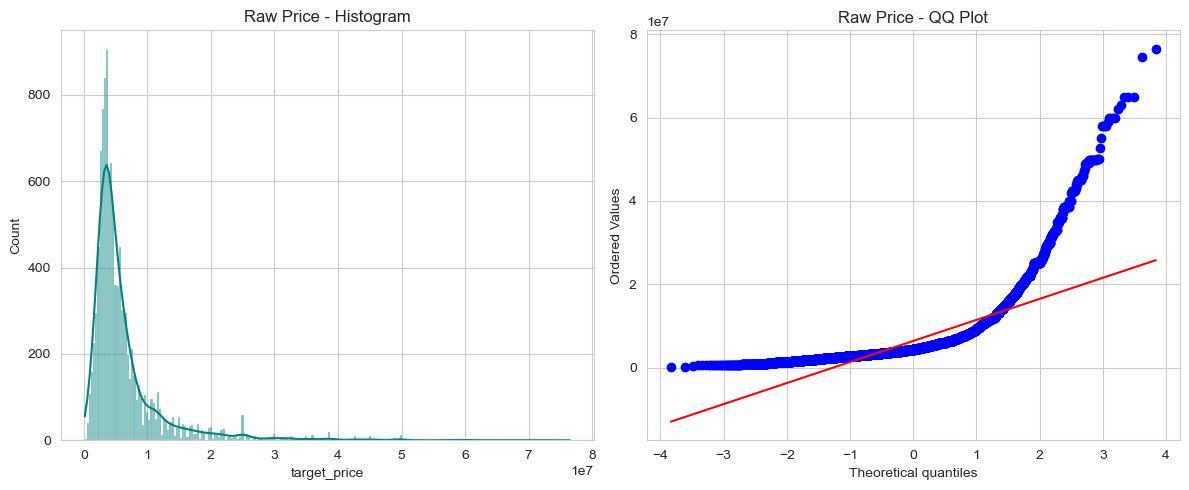

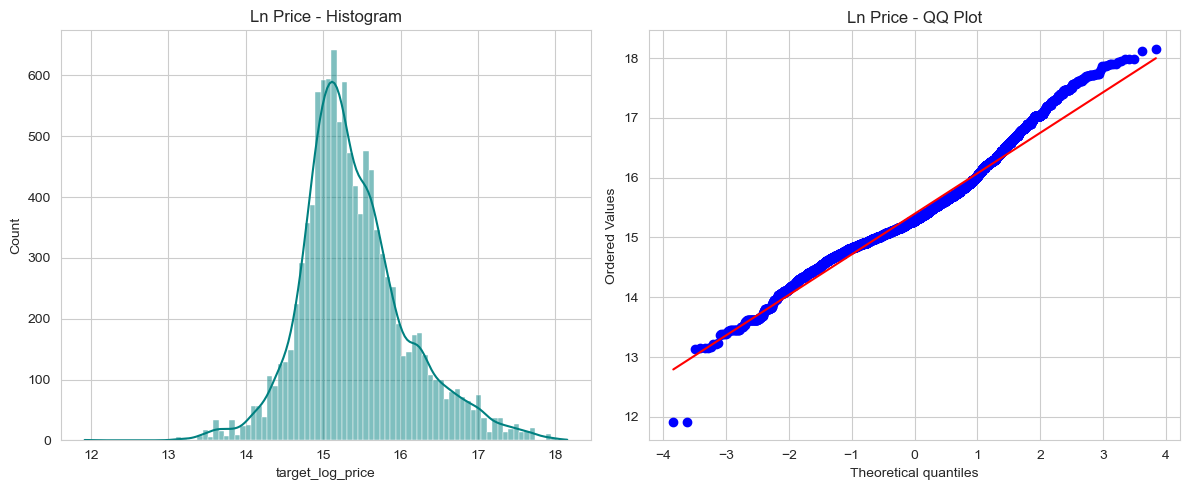

             Metric  Raw Data  Ln Data
   Skewness (Sesgo)     3.746    0.590
Kurtosis (Curtosis)    19.535    1.055

--- VERDICT ---
Skew reduced from 3.75 to 0.59.
Result: Moderately Skewed. Z-score is acceptable but use with caution.


In [29]:
from scipy.stats import probplot, skew, kurtosis

# --- TARGET STATISTICAL REFINEMENT ---

def plot_diagnostics(data, title):
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, color='teal')
    plt.title(f'{title} - Histogram')

    # QQ-Plot
    plt.subplot(1, 2, 2)
    probplot(data, dist="norm", plot=plt)
    plt.title(f'{title} - QQ Plot')

    plt.tight_layout()
    plt.show()

# 1. Analyze Raw Target
plot_diagnostics(df[target_col], "Raw Price")

# 2. Apply Log Transformation
df['target_log_price'] = np.log1p(df[target_col])

# 3. Analyze Log Target
plot_diagnostics(df['target_log_price'], "Ln Price")

# 4. Calculate Moments for Raw vs Log
raw_price = df[target_col]
log_price = np.log1p(df[target_col])

stats_comparison = {
    'Metric': ['Skewness (Sesgo)', 'Kurtosis (Curtosis)'],
    'Raw Data': [skew(raw_price), kurtosis(raw_price)],
    'Ln Data': [skew(log_price), kurtosis(log_price)]
}

df_audit = pd.DataFrame(stats_comparison)
print(df_audit.to_string(index=False))

# 5. Interpretation Logic
print("\n--- VERDICT ---")
current_skew = stats_comparison['Ln Data'][0]

if abs(current_skew) < abs(stats_comparison['Raw Data'][0]):
    print(f"Skew reduced from {stats_comparison['Raw Data'][0]:.2f} to {current_skew:.2f}.")
    if abs(current_skew) <= 0.5:
        print("Result: Fairly Symmetrical. Z-score is now safe to use.")
    elif abs(current_skew) <= 1:
        print("Result: Moderately Skewed. Z-score is acceptable but use with caution.")
    else:
        print("Result: Still highly skewed. We might need a Box-Cox transformation instead of Log.")
else:
    print("No improvement. Log-transformation is not the right tool for this feature.")

In [30]:
from scipy.stats import zscore

# 6. Statistical Outlier Removal (Z-Score)
# We calculate Z-score on the log-transformed data
z_scores = np.abs(zscore(df['target_log_price']))
THRESHOLD = 3  # Standard 3-sigma rule

outliers_mask = z_scores > THRESHOLD
n_outliers = outliers_mask.sum()

if n_outliers > 0:
    print(f"Z-Score Analysis detected {n_outliers} statistical outliers (|z| > {THRESHOLD}).")
    # Dropping those extreme points that don't follow the log-normal distribution
    df = df[~outliers_mask]
    print(f"Statistical outliers removed.")
else:
    print(f"No statistical outliers detected with Z-Score > {THRESHOLD}.")

print("-" * 40)
print(f"Final Row Count: {df.shape[0]:,}")
print("-" * 40)

Z-Score Analysis detected 106 statistical outliers (|z| > 3).
Statistical outliers removed.
----------------------------------------
Final Row Count: 10,979
----------------------------------------


In [ ]:
# --- SPIKE DIAGNOSIS: THE CENTROID HYPOTHESIS ---

# 1. Identificar el valor exacto del pico (Moda)
spike_distance = df['feat_dist_mall'].mode()[0]

# 2. Filtrar las casas que tienen esa distancia EXACTA
spike_df = df[df['feat_dist_mall'] == spike_distance]

print(f"Distancia del Pico: {spike_distance:.4f} metros")
print(f"Cantidad de casas en el pico: {len(spike_df)}")

# 3. LA PRUEBA DE FUEGO: ¿Tienen coordenadas únicas o repetidas?
# (Asumiendo que tienes lat/lon o 'listing_geom' en el df original, si no, usa el ID del barrio si lo tienes)
# Si no tienes lat/lon a la mano, omite este paso, pero es la clave.
if 'feat_latitude' in df.columns:
    unique_locations = spike_df[['feat_latitude', 'feat_longitude']].drop_duplicates().shape[0]
    print(f"Ubicaciones únicas en el pico: {unique_locations}")

    if unique_locations < 5:
        print("🚨 DIAGNÓSTICO: CLUSTER DE CENTROIDES DETECTADO.")
        print("Todas estas casas comparten la misma ubicación geográfica (probablemente el centro de una colonia).")
    else:
        print("✅ DIAGNÓSTICO: Es un desarrollo grande real, las casas tienen ubicaciones distintas.")

#### 5.2.1. Group A Analysis: Heavyweights (Price & Size)
These variables define the property's core value. Even after Stage A cleaning, they may contain **Domain Outliers** (e.g., Ultra-luxury mansions or Industrial properties) that skew the model.

**Strategy:**
1.  **Domain Hard Caps:** We apply a final filter to remove properties that, while technically valid, are outside the scope of a standard residential model (e.g., Price > $80M MXN).
2.  **Log-Transformation:** We apply `np.log1p` to normalize the naturally right-skewed distribution of real estate prices.
3.  **Z-Score Pruning:** We remove statistical outliers (> 3 Standard Deviations) in the log-space to ensure a robust regression.

#### 5.2.2. Group B Analysis: Decay Factors (Distance & Crime)
Variables like "Distance to Park" or "Crime Rate" typically exhibit **Diminishing Marginal Utility** (or Disutility).
* *Example:* The price difference between 0km and 1km is huge; between 20km and 21km is negligible.

**Strategy:**
1.  **Skewness Check:** Identify variables with a long tail (Skew > 1.0).
2.  **Log-Transformation:** Apply `log(x+1)` to linearize these relationships for the regression model.

In [ ]:
# --- GROUP B: SKEWNESS & LOG TRANSFORMATION ---

skewed_feats = []
print(f"Analyzing {len(group_b_decay)} variables for skewness...")

for col in group_b_decay:
    skew = df[col].skew()

    # Apply Log if Skewness > 1.0 (Right-skewed)
    if skew > 1.0:
        new_col = f"ln_{col.replace('feat_', '')}"
        df[new_col] = np.log1p(df[col])
        skewed_feats.append((col, skew))

print(f"\nTransformed {len(skewed_feats)} variables (Skew > 1.0).")
# Show top 3 examples
for original, val in skewed_feats[:3]:
    print(f"   - {original}: Skew={val:.2f} -> created 'ln_{original.replace('feat_', '')}'")

# Visual Proof (Before vs After)
if skewed_feats:
    example_col = skewed_feats[0][0]
    example_log = f"ln_{example_col.replace('feat_', '')}"

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[example_col], ax=ax[0], color='gray', bins=30).set_title(f'Original: {example_col}')
    sns.histplot(df[example_log], ax=ax[1], color='purple', bins=30).set_title(f'Transformed: {example_log}')
    plt.show()

Applying a Log transformation is aggressive. While it fixes Right-Skewness (positive skew), it risks **"Overshooting"**: compressing the data so much that it creates a massive Left-Skew (negative skew).

**Verification Criterion:**
We compare the absolute skewness before and after transformation ($|Skew_{new}| < |Skew_{old}|$).
* **Improved:** The distribution is closer to a Normal shape (0 skew).
* **Overshot:** The transformation was too strong, inverting the skew excessively.
    * *Note:* In economic variables (like distance), we often tolerate a slight overshoot if it linearizes the relationship with Price, even if the distribution isn't perfectly normal.

In [ ]:
# --- GROUP B: TRANSFORMATION QUALITY CHECK ---

print(f"{'Variable':<30} | {'Orig Skew':<10} | {'Log Skew':<10} | {'Status'}")
print("-" * 75)

# Iterate only through transformed variables
transformed_cols = [c for c in df.columns if c.startswith('ln_') and c not in ['ln_price', 'ln_m2_constructed', 'ln_m2_terrain']]

for log_col in transformed_cols:
    # Reconstruct original column name (remove 'ln_' prefix)
    orig_col = f"feat_{log_col.replace('ln_', '')}"

    if orig_col in df.columns:
        orig_skew = df[orig_col].skew()
        new_skew = df[log_col].skew()

        # Check if absolute skewness was reduced (closer to 0)
        # We use abs() because -1.5 is just as bad as +1.5
        improved = abs(new_skew) < abs(orig_skew)

        status = "Improved" if improved else "Overshot **"

        print(f"{orig_col:<30} | {orig_skew:>9.2f}  | {new_skew:>9.2f}  | {status}")

Our initial analysis revealed that the **Log transformation** was too aggressive for certain variables (e.g., `dist_mall`, `dist_industrial`), flipping a moderate positive skew into a strong negative skew ("Overshooting").

**Decision:**
Instead of testing an exhaustive list of functions, we apply a pragmatic **Binary Choice Strategy**:
1.  **Log ($ln(x+1)$):** Best for heavy tails and exponential decay.
2.  **Square Root ($\sqrt{x}$):** A milder transformation, ideal for moderate skewness where Log is too strong.

We will calculate the skewness for both and select the one that brings the distribution closest to zero.

In [ ]:
# --- OPTIMIZED GROUP B TRANSFORMATION ---

for col in group_b_decay:
    skew_orig = df[col].skew()

    if skew_orig > 1.0:

        log_val = np.log1p(df[col])
        sqrt_val = np.sqrt(df[col])

        skew_log = log_val.skew()
        skew_sqrt = sqrt_val.skew()

        # Decision Rule: Choose the one closest to 0
        if abs(skew_log) < abs(skew_sqrt):
            # Log wins
            df[f"ln_{col.replace('feat_', '')}"] = log_val
            method = "Log"
            final_skew = skew_log
        else:
            # Sqrt wins (Note: we still prefix 'ln_' or change to 'sqrt_' to keep track)
            df[f"sqrt_{col.replace('feat_', '')}"] = sqrt_val
            method = "Sqrt"
            final_skew = skew_sqrt

        print(f"Variable: {col:<25} | Orig: {skew_orig:.2f} -> New: {final_skew:.2f} ({method})")

We achieved skewness values between **$\pm 0.6$** for all variables using simple transformations (Log & Sqrt). While algorithms like `PowerTransformer` (Yeo-Johnson) could theoretically push skewness closer to exactly 0, we deliberately stop here for three reasons:

1.  **Explainability:** Log and Sqrt have clear economic interpretations (diminishing marginal utility). Complex fractional powers (e.g., $x^{-0.32}$) are "black boxes" to stakeholders.
2.  **Diminishing Returns:** For a Linear Regression model, the current distribution shapes are sufficient to satisfy linearity assumptions. Further optimization yields negligible predictive gains.
3.  **Robustness:** Simpler transformations are less prone to overfitting and easier to maintain in a production pipeline than data-dependent lambdas.

We consider "Decay Factors" (Group B) to be now statistically healthy and ready for modeling.

In [ ]:
example_col = 'feat_dist_mall'
example_log = f"ln_{example_col.replace('feat_', '')}"
example_sqrt = f"sqrt_{example_col.replace('feat_', '')}"

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df[example_col], ax=ax[0], color='gray', bins=30).set_title(f'Original: {example_col}')
sns.histplot(df[example_log], ax=ax[1], color='purple', bins=30).set_title(f'Log: {example_log}')
sns.histplot(df[example_sqrt], ax=ax[2], color='purple', bins=30).set_title(f'Sqrt: {example_sqrt}')
plt.show()

#### 5.2.3. Group C Analysis: Discrete Counters
These variables (Bedrooms, Bathrooms, Parking) were capped and cleaned in **Stage A**.
Here, we visualize their distribution to confirm they are well-behaved and ready for modeling. No further filtering is required.

In [ ]:
# --- GROUP C: DISTRIBUTION CHECK ---

# No filtering here. Just confirmation.
print(f"--- GROUP C SUMMARY (Post-Stage A Capping) ---")
print(df[group_c_counters].describe().loc[['min', 'max', 'mean']])

# Visual Check using Countplots (better for discrete data than histograms)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot first 3 counters as sanity check
for i, col in enumerate(group_c_counters[:3]):
    if i < 3:
        sns.countplot(x=df[col], ax=axes[i], palette='viridis')
        axes[i].set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

#### 5.2.4. Group D Analysis: Boolean & Categorical Variance
This group includes binary amenities (Pool, Gym) and the One-Hot Encoded municipalities from Stage A.

**Strategy:**
* **Low Variance Filter:** If a feature is present/absent in more than **99.5%** of the data, it lacks sufficient variance to be predictive and is removed to reduce noise.

In [ ]:
# --- GROUP D: LOW VARIANCE FILTER ---

# Threshold: 99.5% constant (e.g., if only 0.5% of houses have a "Tennis Court")
variance_threshold = 0.995
cols_to_drop = []

print(f"Checking {len(group_d_booleans)} boolean variables for low variance...")

for col in group_d_booleans:
    # Calculate frequency of the most common value
    top_freq = df[col].value_counts(normalize=True).iloc[0]

    if top_freq > variance_threshold:
        cols_to_drop.append((col, top_freq))

# Execution
if cols_to_drop:
    print(f"\nDROPPING {len(cols_to_drop)} columns (Constant > {variance_threshold*100}%):")
    for col, freq in cols_to_drop:
        print(f"   - {col}: {freq:.2%} constant")

    # Drop from dataframe
    drop_list = [x[0] for x in cols_to_drop]
    df.drop(columns=drop_list, inplace=True)
else:
    print("\nAll boolean variables have sufficient variance.")

print(f"\n--- FINAL DATASET SHAPE: {df.shape} ---")

## 6. Diagnosing Multicollinearity (The "Bedroom" Issue)

To confirm why the bedroom coefficient is negative, we need to check how strongly the physical variables relate to each other.

**Tools used:**
1.  **Correlation Matrix:** Visual inspection of relationships.
2.  **VIF (Variance Inflation Factor):** A statistical measure quantifying how much the variance of a coefficient is inflated due to multicollinearity.
    * *Rule of Thumb:* VIF > 5 indicates high multicollinearity. VIF > 10 requires immediate action (dropping variables).

In [ ]:
# --- A. Correlation Matrix Heatmap ---
# Calculate correlation matrix
corr_matrix = df[['target_price', 'feat_bedrooms', 'feat_bathrooms',
                  'feat_m2_constructed', 'feat_parking_spots']].corr()

# Plot
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hide upper triangle

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap='RdBu_r',
            vmax=1,
            vmin=-1,
            linewidths=.5)

plt.title('Correlation: Physical Features vs Price', fontsize=14)
plt.show()

# --- B. Variance Inflation Factor (VIF) Calculation ---
# Select only numeric features for VIF check (excluding target)
features_for_vif = df[['feat_bedrooms', 'feat_bathrooms',
                       'feat_m2_constructed', 'feat_parking_spots']].dropna()

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(features_for_vif.values, i)
                   for i in range(len(features_for_vif.columns))]

print("\n--- Variance Inflation Factor (VIF) Results ---")
print(vif_data.sort_values(by="VIF", ascending=False))